In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import sklearn.neighbors

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Setup feature extractor

In [3]:
import tensorflow as tf
import keras

configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "1"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
net = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', pooling=True)

In [5]:
def preprocess(im):
    
    # Check channels
    if len(im.shape) == 2: 
        im = skimage.color.gray2rgb(im)
    elif im.shape[2] >= 3:
        im = im[:,:,0:3]
        
    # Resize
    im = skimage.transform.resize(im, (299,299))
    
    # Preprocess
    im = keras.applications.inception_resnet_v2.preprocess_input(im)
    
    return np.expand_dims(im, axis=0)
    

# Load unlabeled data

In [6]:
training_dir = "/storage/data/DSB2018/training-data/"

names = []
unlabeled = []

for im_name in os.listdir(training_dir):
    im = skimage.io.imread(f"{training_dir}{im_name}/images/{im_name}.png")
    x = preprocess(im)
    features = net.predict(x)
    features = np.sum(np.sum(np.sum(features, axis=0), axis=0), axis=0)
    unlabeled.append(np.expand_dims(features, axis=0))
    names.append(im_name)

/home/0x00b1/com/github/scikit-image/scikit-image/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/0x00b1/com/github/scikit-image/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Load labeled data

In [7]:
data_dir = "/storage/data/DSB2018/"

image_groups = pd.read_csv(data_dir + "metadata/image_groups_defined_by_beth.csv")

labeled = []

for i,r in image_groups.iterrows():
    im = skimage.io.imread(f"{data_dir}phase-2-imgs/{r.Image}.png")
    x = preprocess(im)
    features = net.predict(x)
    features = np.sum(np.sum(np.sum(features, axis=0), axis=0), axis=0)
    labeled.append(np.expand_dims(features, axis=0))

/home/0x00b1/com/github/scikit-image/scikit-image/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/0x00b1/com/github/scikit-image/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [8]:
categories = {}
i = 0
image_groups["Category"] = 0
for g in image_groups["Group"].unique():
    image_groups.loc[image_groups.Group == g, "Category"] = i
    categories[i] = g
    i += 1
    
categories

{0: 'Purple', 1: 'TissueBW', 2: 'PinkAndPurple', 3: 'Superbig', 4: 'Default'}

# Classify unlabeled images

In [13]:
training_samples.shape

(106, 1536)

In [14]:
training_samples = np.concatenate(labeled, axis=0)
training_labels = np.asarray( image_groups["Category"] )
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
neigh.fit(training_samples, image_groups["Category"]) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [15]:
test_samples = np.concatenate(unlabeled, axis=0)
predictions = neigh.predict(test_samples)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb739e601d0>,
 {0: 'Purple', 1: 'TissueBW', 2: 'PinkAndPurple', 3: 'Superbig', 4: 'Default'})

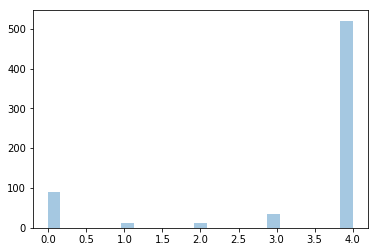

In [16]:
sb.distplot(predictions, kde=False), categories

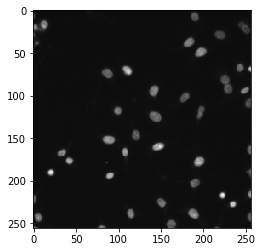

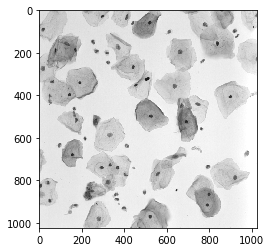

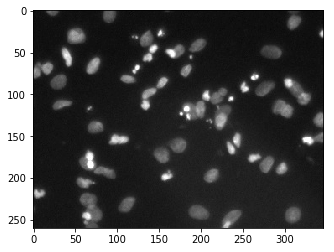

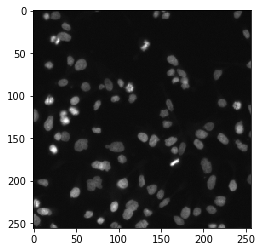

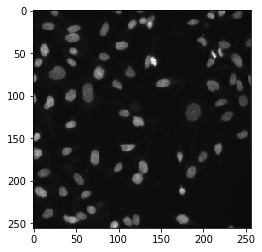

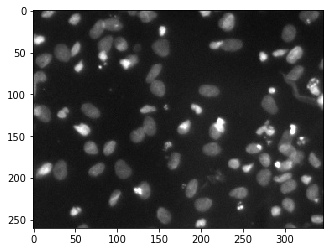

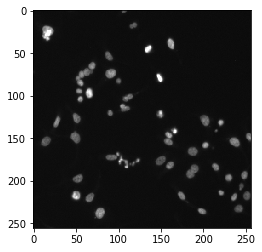

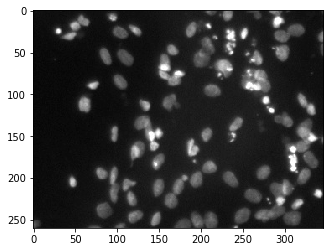

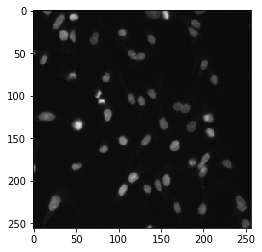

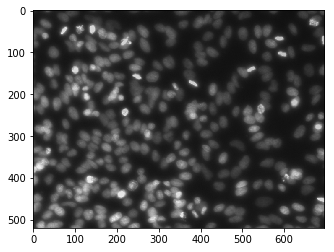

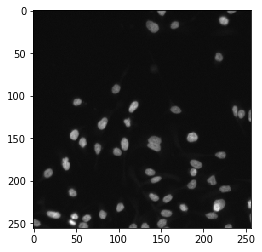

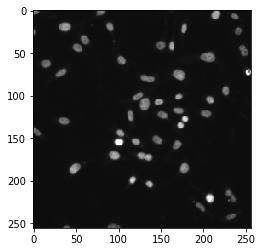

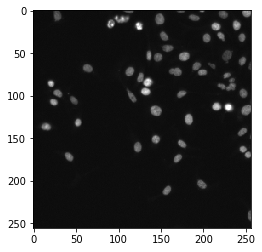

In [26]:
for i in range(len(unlabeled)):
    if predictions[i] == 1:
        plt.figure()
        im = skimage.io.imread(f"{training_dir}{names[i]}/images/{names[i]}.png")
        plt.imshow(im)